In [1]:
from models import T5EncoderClassifier, T5Classifier, BertTextClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

from load_dataset import add_label_id
import torch
import load_dataset
import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
device = "mps"
model = torch.load("./bert_results/model/model.pt", map_location=device)

In [3]:
simplified_labels = ["Web", "International", "Etat", "Wirtschaft", "Panorama", "Sport", "Wissenschaft", 
                     "Kultur", "Heimat"]
decoder_attentionmask = [1 for _ in range(len(load_dataset.label_to_id))]
decoder_inputs = [model.tokenizer(simplified_label).input_ids[0] for simplified_label in simplified_labels]
def tokenize_function(examples):
    if model.is_transformer:
        input_tokenized = model.tokenizer(examples["text"], padding="max_length", max_length=512, truncation=True)
        return {"input_ids": input_tokenized.input_ids, "input_attention_mask": input_tokenized.attention_mask,
                "decoder_ids": decoder_inputs, "decoder_attention_mask": decoder_attentionmask }
    else:
        if type(model) == T5EncoderClassifier:
            return model.tokenizer(examples["text"], padding="max_length", max_length=512, truncation=True)
        else:
            return model.tokenizer(examples["text"], padding="max_length", truncation=True)


In [4]:
_, test_ds = load_dataset.load_dataset("../German_newspaper_articles/10kGNAD/train.csv", 
                                 "../German_newspaper_articles/10kGNAD/test.csv")

In [5]:
test_ds = test_ds.map(tokenize_function)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [6]:
test_ds = test_ds.map(add_label_id)

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [14]:
y_true = []
y_pred = []
wrong = []
def test():
    model.eval()
    test_ds.set_format("torch", device=device)
    start_time = time.perf_counter()
    for data in test_ds:
        label_id = torch.unsqueeze(data['label_id'], 0)
        if model.is_transformer:
            output = model(torch.unsqueeze(data['input_ids'], 0), torch.unsqueeze(data['input_attention_mask'], 0),
                        torch.unsqueeze(data['decoder_ids'], 0), torch.unsqueeze(data['decoder_attention_mask'], 0))
        else:
            output = model(torch.unsqueeze(data['input_ids'], 0), torch.unsqueeze(data['attention_mask'], 0))      
        output = torch.argmax(output)
        global y_true
        global y_pred
        y_true.append(load_dataset.id_to_label[label_id.item()])
        y_pred.append(load_dataset.id_to_label[output.item()])

        if label_id.item() is not output.item():
            global wrong
            item = {"text": data["text"], "prediction": load_dataset.id_to_label[output.item()], "label": data["label"]}
            wrong.append(item)
    end_time = time.perf_counter()
    print(f"Test took {(end_time - start_time)/60:0.4f} minutes")


In [15]:
test()

Test took 2.2090 minutes


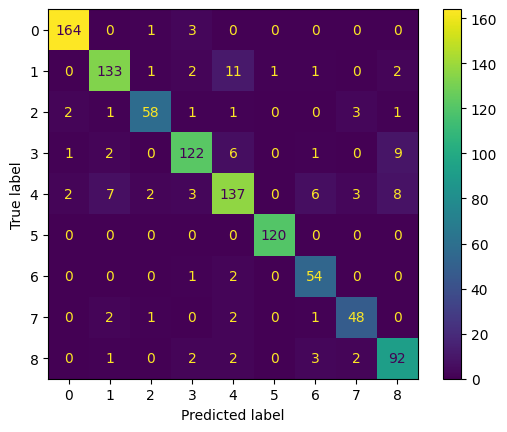

In [16]:
cm = confusion_matrix(y_true, y_pred, labels=["Web", "International", "Etat", "Wirtschaft", "Panorama", "Sport", "Wissenschaft", "Kultur", "Inland"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [22]:
accuracy_score(y_true, y_pred)

0.9027237354085603

In [25]:
f1_score(y_true, y_pred, average="weighted")

0.9026619030984329